# Sentiment analysis of Amazon baby product reviews

In [1]:
import itertools, re, math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import nltk
from nltk import PorterStemmer
from nltk import word_tokenize, casual_tokenize, FreqDist
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
%matplotlib inline

In [2]:
#pretty confusion plot function, shamelessly stolen from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Load & prepare data

In [3]:
df = pd.read_csv('Amazon_Baby_train.txt', sep=' ;  ', index_col=False, header=None,
                     names=['Rating', 'Product', 'Review'], engine='python');

products = df.values[:, 1].astype(str)
reviews  = df.values[:, 2].astype(str)
ratings  = df.values[:, 0].astype(int)

### Preprocessing: stem the words, stopwords will be removed by the countvectorizer which is more performant

In [4]:
stemmer = PorterStemmer()
stop_words = stopwords.words('english') + ['.']

x = [stemmer.stem(review) for review in reviews]
y = ratings

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=9000)

print(len(reviews))
print(len(x))

146861
146861


## Analyze & visualize data

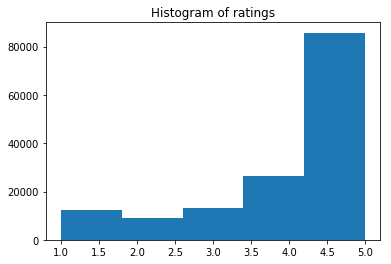

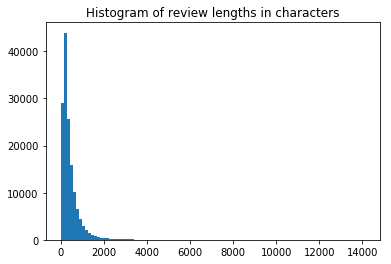

total reviews:    146861
unique products:  29594


In [5]:
plt.hist(ratings, bins=5)
plt.title('Histogram of ratings')
plt.show()
plt.hist(list(map(lambda review: len(review), reviews)), bins=100)
plt.title('Histogram of review lengths in characters')
plt.show()
print('total reviews:   ', len(reviews))
print('unique products: ', len(set(products)))

## Task 1: Sentiment score

In [6]:
sentiment_analyzer = Pipeline([('vectorizer', CountVectorizer(tokenizer=lambda x: casual_tokenize(x, preserve_case=False, reduce_len=True, strip_handles=True),
                                                              analyzer='word',
                                                              stop_words=stop_words,
                                                              ngram_range=(1, 1) # (1, 1) yields the best results
                                                             )),
                               #('tfidftransformer', TfidfTransformer(use_idf=False)), # using tfidf here does not help...
                               ('classifier', MultinomialNB())])

In [7]:
sentiment_analyzer.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['i',...      vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [8]:
sentiment_analyzer.named_steps['vectorizer'].vocabulary_

{'son': 74192,
 'autistic': 10542,
 'loves': 48071,
 'puzzles': 64251,
 'hard': 38389,
 'time': 81335,
 'paying': 59076,
 'attention': 10408,
 'shapes': 71173,
 'puzzle': 64248,
 'right': 67955,
 'complexity': 21046,
 'level': 46638,
 'himm': 39682,
 'self': 70483,
 'would': 90001,
 'highly': 39568,
 'reccommend': 65819,
 'product': 63064,
 'look': 47734,
 'amazing': 8406,
 "that's": 79744,
 'ends': 29645,
 'fragile': 34233,
 'film': 32566,
 'sooo': 74310,
 'thin': 80510,
 'rub': 68637,
 'rather': 65116,
 'long': 47619,
 'come': 20462,
 'away': 10745,
 'protective': 63545,
 'cover': 22509,
 'took': 82221,
 'least': 46362,
 '10': 2872,
 'minute': 50717,
 'per': 59403,
 'cloud': 19871,
 'place': 60452,
 'reach': 65493,
 'animals': 8792,
 'children': 18741,
 'take': 78871,
 'much': 52249,
 'scratched': 69724,
 'wrinkle': 90137,
 'buy': 16570,
 'daughter': 24101,
 'booster': 14570,
 'seat': 69985,
 'soft': 73864,
 ',': 2589,
 'car': 17187,
 'rides': 67907,
 'painful': 58401,
 'especially':

In [9]:
y_pred = sentiment_analyzer.predict(x_test)

Confusion matrix, without normalization
[[ 1260    46   132   270   751]
 [  405    39   188   430   752]
 [  214    27   248   865  1217]
 [  138     7   117  1622  3402]
 [  230    17    67  1051 15878]]


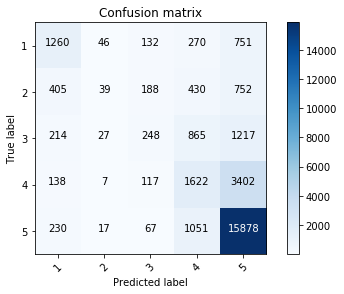

Normalized confusion matrix
[[0.51 0.02 0.05 0.11 0.31]
 [0.22 0.02 0.1  0.24 0.41]
 [0.08 0.01 0.1  0.34 0.47]
 [0.03 0.   0.02 0.31 0.64]
 [0.01 0.   0.   0.06 0.92]]


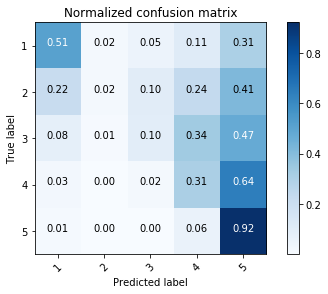

Accuracy =  0.6484526606066796


In [10]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
class_names = [1,2,3,4,5]

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

print('Accuracy = ', accuracy_score(y_test, y_pred))

## Task 2: Optimize F1 score for ratings 4 and 5

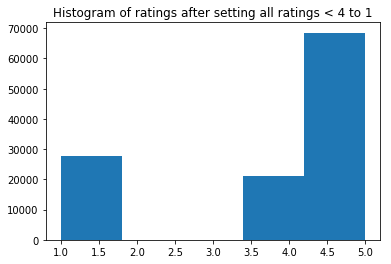

In [11]:
y_train_modified = list(map(lambda x: 1 if x < 4 else x, y_train))
#y_train_modified = list(filter(lambda y: y > 3, y_train)) # no good results using only these examples
x_train_modified = x_train #[x for i,x in enumerate(x_train) if y_train[i] > 3]
plt.hist(y_train_modified, bins=5)
plt.title('Histogram of ratings after setting all ratings < 4 to 1')
plt.show()

In [12]:
sentiment_analyzer = Pipeline([('vectorizer', CountVectorizer(tokenizer=lambda x: casual_tokenize(x, preserve_case=False, reduce_len=True, strip_handles=True),
                                                              analyzer='word',
                                                              stop_words=stop_words,
                                                              ngram_range=(1, 1) # (1, 1) yields the best results
                                                             )),
                               #('tfidftransformer', TfidfTransformer()), # using tfidf here does not help...
                               ('classifier', MultinomialNB())])

In [13]:
sentiment_analyzer.fit(x_train_modified, y_train_modified)  

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['i',...      vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [14]:
y_pred = sentiment_analyzer.predict(x_test)

Confusion matrix, without normalization
[[ 2007     0     0    61   391]
 [ 1219     0     0   141   454]
 [ 1174     0     0   466   931]
 [  863     0     0  1253  3170]
 [  992     0     0   801 15450]]


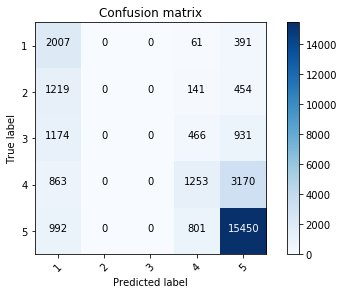

Normalized confusion matrix
[[0.82 0.   0.   0.02 0.16]
 [0.67 0.   0.   0.08 0.25]
 [0.46 0.   0.   0.18 0.36]
 [0.16 0.   0.   0.24 0.6 ]
 [0.06 0.   0.   0.05 0.9 ]]


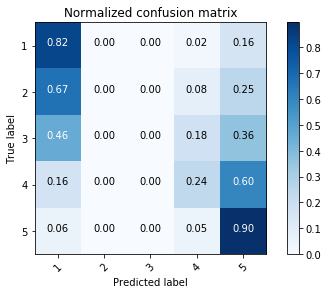

F1 Score for class 5 =  0.820956986104838
F1 Score for class 4 =  0.31293706293706297
F1 Score mean for class 4 and 5 =  0.5669470245209505


C:\Users\patri\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [15]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
class_names = [1,2,3,4,5]

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

fscores = f1_score(y_test, y_pred, average=None)
print('F1 Score for class 5 = ', fscores[4])
print('F1 Score for class 4 = ', fscores[3])
print('F1 Score mean for class 4 and 5 = ', (fscores[3] + fscores[4])/2)

## Task 3: Optimize F1 Score for rating 1

In [40]:
# find most common words in negative reviews
words = []
for i, r in enumerate(x_train):
    if y_train[i] == 4:
        for w in casual_tokenize(r, preserve_case=False, reduce_len=True, strip_handles=True):
            if w not in stop_words:
                words.append(w)
        
fd = FreqDist(words)
fd.most_common()

[(',', 61160),
 ('!', 10620),
 (')', 8968),
 ('one', 8878),
 ('baby', 8551),
 ('(', 8424),
 ('like', 8216),
 ('would', 7839),
 ('great', 7381),
 ('use', 6877),
 ('little', 6625),
 ('-', 6434),
 ('seat', 6190),
 ('get', 5364),
 ('easy', 5350),
 ('really', 5230),
 ('well', 5024),
 ('good', 4918),
 ('old', 4434),
 ('love', 4227),
 ('also', 4145),
 ('"', 3953),
 ('stroller', 3911),
 ('time', 3851),
 ('put', 3768),
 ('product', 3743),
 ('much', 3597),
 ('son', 3574),
 ('still', 3520),
 ('back', 3471),
 ('&', 3349),
 ('bought', 3310),
 ('car', 3161),
 ('...', 3155),
 ('used', 3138),
 ('nice', 3096),
 ('daughter', 3022),
 ('months', 3008),
 ('2', 2917),
 ('/', 2870),
 ("i'm", 2740),
 ('first', 2729),
 ('could', 2719),
 ('fit', 2696),
 ('bag', 2645),
 ('around', 2551),
 ('two', 2539),
 ('even', 2520),
 (':', 2512),
 ('small', 2489),
 ('bit', 2487),
 ('think', 2485),
 ('using', 2406),
 ('enough', 2403),
 ('price', 2385),
 ('4', 2365),
 ('5', 2340),
 ('got', 2338),
 ('works', 2312),
 ('loves', 2

In [17]:
# find most common words in non-negative reviews
words = []
for i, r in enumerate(x_train):
    if y_train[i] != 5:
        for w in casual_tokenize(r, preserve_case=False, reduce_len=True, strip_handles=True):
            if w not in stop_words:
                words.append(w)
        
fd = FreqDist(words)
fd.most_common()

[(',', 141136),
 ('!', 25350),
 ('one', 20877),
 ('would', 19745),
 (')', 19098),
 ('baby', 19035),
 ('(', 17920),
 ('like', 17281),
 ('use', 15206),
 ('-', 14993),
 ('get', 13415),
 ('seat', 12755),
 ('great', 12261),
 ('really', 11317),
 ('little', 11299),
 ('product', 10769),
 ('"', 10108),
 ('good', 9703),
 ('time', 9696),
 ('well', 9632),
 ('also', 9181),
 ('old', 9076),
 ('back', 8880),
 ('...', 8738),
 ('much', 8688),
 ('bought', 8371),
 ('easy', 7996),
 ('put', 7996),
 ('even', 7704),
 ('stroller', 7564),
 ('son', 7484),
 ('first', 7158),
 ('&', 7135),
 ('still', 7037),
 ('months', 7031),
 ('2', 6831),
 ('used', 6831),
 ('could', 6750),
 ('love', 6499),
 ('work', 6366),
 ("i'm", 6349),
 ('/', 6189),
 ('fit', 6088),
 ('two', 6077),
 ('car', 6059),
 ('daughter', 6022),
 ('got', 5950),
 ('bag', 5928),
 ('way', 5861),
 ('better', 5734),
 ('using', 5505),
 (':', 5432),
 ('nice', 5393),
 ('small', 5371),
 ('buy', 5286),
 ('around', 5247),
 ('enough', 5224),
 ('think', 5209),
 ('howev

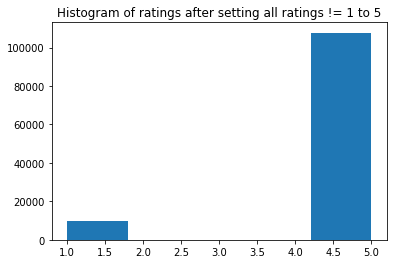

In [18]:
y_train_modified = list(map(lambda x: 1 if x == 1 else 5, y_train))

x_train_modified = x_train
plt.hist(y_train_modified, bins=5)
plt.title('Histogram of ratings after setting all ratings != 1 to 5')
plt.show()

In [19]:
# using only a subset of the data because the dataset is very skewed
x_train_neg = [x for i,x in enumerate(x_train) if y_train[i] == 1]
x_train_pos = [x for i,x in enumerate(x_train) if y_train[i] > 1]
x_train_pos = x_train_pos[:len(x_train_neg)*5] # still skewed, but 5 times more positive examples seems to yield the best result...

x_train_modified = x_train_neg + x_train_pos
y_train_modified = [1 for i in range(len(x_train_neg))] + [5 for i in range(len(x_train_pos))]
len(x_train_modified)

58776

In [20]:
sentiment_analyzer = Pipeline([('vectorizer', CountVectorizer(tokenizer=lambda x: casual_tokenize(x, preserve_case=False, reduce_len=True, strip_handles=True),
                                                              analyzer='word',
                                                              stop_words=stop_words,
                                                              ngram_range=(1, 1) 
                                                             )),
                               #('tfidftransformer', TfidfTransformer()), # using tfidf here does not help...
                               ('classifier', MultinomialNB())])

In [21]:
sentiment_analyzer.fit(x_train_modified, y_train_modified)  

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['i',...      vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [22]:
#predict
negative_indicators = ["doesn't work","waste", 'frustrate',' disappoint', 'bad', 'worst', ':(', ':-(', 'not recommend', "don't recommend", "don't buy", 'never again', 'never buy'] #hardcode some rules
y_pred = sentiment_analyzer.predict(x_test)
adjusted = 0
for i, r in enumerate(x_test):
    for ni in negative_indicators:
        if ni in r:
            y_pred[i] = 1
            adjusted = adjusted + 1
print(adjusted)

3122


Confusion matrix, without normalization
[[ 1710     0     0     0   749]
 [  811     0     0     0  1003]
 [  601     0     0     0  1970]
 [  516     0     0     0  4770]
 [  960     0     0     0 16283]]


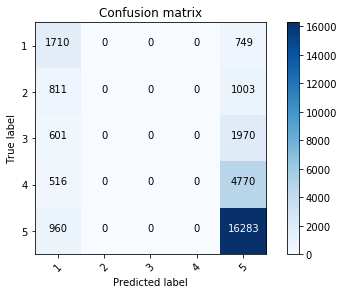

Normalized confusion matrix
[[0.7  0.   0.   0.   0.3 ]
 [0.45 0.   0.   0.   0.55]
 [0.23 0.   0.   0.   0.77]
 [0.1  0.   0.   0.   0.9 ]
 [0.06 0.   0.   0.   0.94]]


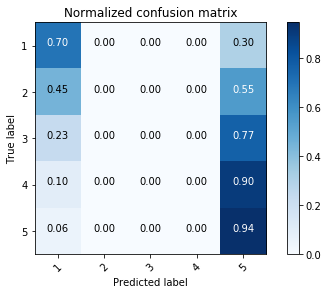

F1 Score for class 1 =  0.48462519484200084


C:\Users\patri\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
class_names = [1,2,3,4,5]

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

fscores = f1_score(y_test, y_pred, average=None)
print('F1 Score for class 1 = ', fscores[0])

## Task 4: Emotionality of reviews
To find good ways to measure emotionality, I first analyze the reviews according to some criterias and then build a function `emotionality(review)` using the criterias that seem most likely to yield reasonable results.

### Analyze reviews with score 1 or 5 (intuitively the most emotional reviews)

In [24]:
emotional_reviews = [casual_tokenize(review) for review, rating in zip(reviews, ratings) if rating == 5 or rating == 1]

In [25]:
emotional_words = list(itertools.chain(*emotional_reviews))
stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + ['.', ',']
emotional_words = [word for word in emotional_words if word.lower() not in stopwords]

In [26]:
FreqDist(emotional_words).most_common()

[('!', 91048),
 ('one', 36043),
 ('baby', 35849),
 (')', 28681),
 ('great', 27682),
 ('(', 27354),
 ('use', 25941),
 ('would', 24270),
 ('like', 21930),
 ('-', 21768),
 ('love', 21485),
 ('easy', 20726),
 ('seat', 20559),
 ('old', 20198),
 ('little', 20019),
 ('get', 18962),
 ('well', 17899),
 ('product', 17249),
 ('time', 16659),
 ('bought', 15794),
 ('son', 15450),
 ('really', 15186),
 ('also', 14503),
 ('"', 14218),
 ('&', 14084),
 ('much', 14018),
 ('months', 13591),
 ('daughter', 13576),
 ('...', 13400),
 ('loves', 13168),
 ('put', 13065),
 ('recommend', 12401),
 ('stroller', 11982),
 ('car', 11931),
 ('used', 11865),
 ('even', 11811),
 ('back', 11726),
 ('good', 11640),
 ('first', 11119),
 ('2', 10983),
 ('still', 10870),
 ('bag', 9747),
 ('got', 9734),
 ('perfect', 9492),
 ('two', 9427),
 ('using', 9283),
 ('around', 9107),
 ('/', 9064),
 ('buy', 8784),
 ('fit', 8625),
 ("I'm", 8476),
 ('nice', 8445),
 ('month', 8408),
 ('could', 8407),
 ('enough', 8395),
 ('made', 8307),
 ('3',

### Find reviews containing (sequences of) special/exclamation characters

In [27]:
pattern = re.compile('[.?]{2,}|[!]+')
specialchar_reviews = [review for review in reviews if pattern.match(review)]

In [28]:
print(specialchar_reviews[:10])

["...make sure I tell people about this product. I read the reviews, and at the time, this was the only diaper pail that got any decent reveiws, and now I know why. I bought one for upstairs, and liked it so much I bought one for downstairs. I still have on in my registery hoping someone will get me a third one for my mother in law's house. I just use a standard pull string kitchen trash bag, and use it according to the instructions (in other words if you follow the procedure of opening and sinching the bag before removal then you won't have a problem) and it works great, good design!", "... than deal with the odor from this pail.  Even changing the whole bag (we tried plastic grocery sacks, tall kitchen bags, even heavy duty garbage bags) every day didn't help.  We've moved this product to the garage and purchased a Diaper Genie for the nursery.", "......all I can say is the smell is horrible.....1 star..... Please don't buy this one!", "... and I'm one of them. It's not water-tight, 

### Find reviews containing UPPERCASE words

In [29]:
pattern = re.compile('[A-Z]{2,}')
uppercase_reviews = [review for review in reviews if pattern.match(review)]

In [30]:
print(uppercase_reviews[:10])

['OMG.....we loved this baby book! Perfect for the memories you want to remember when your little one gets bigger and starts asking questions. It even had a place for foot and hand prints for when your baby is born which is the main reason why we liked this one. Also it has pockets for keepsakes and little places to put first locks of hair....etc! So cute and is a great baby shower gift!', 'GOOD POINTS:Easy to operate and change.Less expensive to use than comperable products.Kept smell in for several months as other products did.We were unable to break it after 10 mos unlike competitors.BAD POINTS:Toddler kept flipping it back and forth and touching where we put the diapers.Did not keep room odor free after several mos of use.', 'TOTALLY Useless! The 2 pieces will not stay together when you put any kind of pressure on the cord.  Get some retrofits at Window Coverings Safety Council instead!', 'BOUGHT THIS FOR MY DAUGHTER WHEN SHE WAS 2 MONTHS OLD. NOW 8 MONTHS STILL USING IT. I LIKED T

### Find reviews containing emoticons

In [31]:
emoticons = [':)', '(:', ':-)', ')-:', ':D', ':-D', ':P', ':p', ':-P', ':-p', 'xD', 'TT', '><', '^^']
emoticon_reviews = [review for review in reviews if any(emoticon in review for emoticon in emoticons)]

In [32]:
print(emoticon_reviews[:10])

["Although I haven't seen it, my 2 year old niece loves it and that's what matters, so all is well :)", 'Not that==> I &lt==would -- ever -- do it, or recommend it, but there is a gag called theRattlesnake Eggsprank.It is nothing more than a simple mechanism hidden in an envelope that says:"WARNING: RATTLESNAKE EGGS. KEEP AWAY FROM HEAT TO AVOID HATCHING!"I can just picture someone putting a few of these prank envelopes in the backseat of"somebody\'s" car next to one of these snakes. The first slight bump -- while driving --will produce a r=a=t=t=l=i=n=g sound which should MORE than just shake someone upwhen they look behind them and noticethe SNAKE!What an excellent, cruel, gag. Not for your parents---or grand parents---for OBVIOUS reasons!', "My son is obsessed with this teether!! He was first more fascinated with spinning the bottom part and chewing on that but after 4 months of having it, he has now switched and loves the rubber/vibrating part. I don't know what I would do without 

### Find reviews containing intuitively emotional words

In [33]:
#most of these words were taken from https://karlamclaren.com/emotional-vocabulary-page/
emotional_words = ['love','annoy','displease','frustrat','impatient','angry','arrogant','mad','offend','sarcastic','aggressiv','appall','bitter','disgusted','furious','hate','hostile','irate','livid','menacing','outraged','ranting','raving','seething','spiteful','vengeful','vicious','vindictive','violent','alert','apprehensive','cautious','concerned','confused','curious','disconcerted','disoriented','disquieted','doubtful','edgy','fidgety','hesitant','indecisive','insecure','instinctive','intuitive','leery','pensive','shy','timid','uneasy','watchful','afraid','alarmed','anxious','aversive','distrustful','fearful','jumpy','nervous','perturbed','rattled','shaky','startled','suspicious','unnerved','unsettled','wary','worried','horrified','panicked','paralyzed','phobic','shocked','terrorized','encouraged','friendly','hopeful','inspired','peaceful','cheerful','delighted','excited','fulfilled','glad','happy','joyful','lively','merry','optimistic','playful','proud','satisfied','blissful','ecstatic','euphoric','giddy','manic','thrilled','disappointed','grounded','regret','discouraged','melancholy','sad','anguished','depressed','despairing','heartbroken','hopeless','awkward','humble','speechless','withdrawn','ashamed','embarrassed','guilty','humbled','intimidated','degraded','disgraced','humiliated','insecure','protective','suspicious','vulnerable','demanding','desirous','envious','jealous','threatened','grasping','greedy','possessive','enraged','depressed','discouraged','helpless','humorless','impulsive','indifferent','isolated','lethargic','listless','melancholy','pessimistic','purposeless','crushed','despair','desperate','drain','hopeless','joyless','miserable','morbid','overwhelmed','passion','pleasure','sullen','doom','gutt','nihilistic','numbed','reckless','suicidal','tormented','tortured']
emotional_words = [PorterStemmer().stem(w) for w in emotional_words]
emotional_reviews = [review for review in x if any(emotional_word in review.lower() for emotional_word in emotional_words)]

In [34]:
print(emotional_reviews[:10])

['it came early and was not disappointed. i love planet wise bags and now my wipe holder. it keps my osocozy wipes moist and does not leak. highly recommend it.', 'this is a product well worth the purchase.  i have not found anything else like this, and it is a positive, ingenious approach to losing the binky.  what i love most about this product is how much ownership my daughter has in getting rid of the binky.  she is so proud of herself, and loves her little fairy.  i love the artwork, the chart in the back, and the clever approach of this tool.', "all of my kids have cried non-stop when i tried to ween them off their pacifier, until i found thumbuddy to love's binky fairy puppet.  it is an easy way to work with your kids to allow them to understand where their pacifier is going and help them part from it.this is a must buy book, and a great gift for expecting parents!!  you will save them soo many headaches.thanks for this book!  you all rock!!", "when the binky fairy came to our h

## Define emotionality as sum of log matches from previously tested patters

In [35]:
def emotionality(review):
    emoticons = [':)', '(:', ':-)', ')-:', ':D', ':-D', ':P', ':p', ':-P', ':-p', 'xD', 'TT', '><', '^^']
    emotional_words = ['love','annoy','displease','frustrat','impatient','angry','arrogant','mad','offend','sarcastic','aggressiv','appall','bitter','disgusted','furious','hate','hostile','irate','livid','menacing','outraged','ranting','raving','seething','spiteful','vengeful','vicious','vindictive','violent','alert','apprehensive','cautious','concerned','confused','curious','disconcerted','disoriented','disquieted','doubtful','edgy','fidgety','hesitant','indecisive','insecure','instinctive','intuitive','leery','pensive','shy','timid','uneasy','watchful','afraid','alarmed','anxious','aversive','distrustful','fearful','jumpy','nervous','perturbed','rattled','shaky','startled','suspicious','unnerved','unsettled','wary','worried','horrified','panicked','paralyzed','phobic','shocked','terrorized','encouraged','friendly','hopeful','inspired','peaceful','cheerful','delighted','excited','fulfilled','glad','happy','joyful','lively','merry','optimistic','playful','proud','satisfied','blissful','ecstatic','euphoric','giddy','manic','thrilled','disappointed','grounded','regret','discouraged','melancholy','sad','anguished','depressed','despairing','heartbroken','hopeless','awkward','humble','speechless','withdrawn','ashamed','embarrassed','guilty','humbled','intimidated','degraded','disgraced','humiliated','insecure','protective','suspicious','vulnerable','demanding','desirous','envious','jealous','threatened','grasping','greedy','possessive','enraged','depressed','discouraged','helpless','humorless','impulsive','indifferent','isolated','lethargic','listless','melancholy','pessimistic','purposeless','crushed','despair','desperate','drain','hopeless','joyless','miserable','morbid','overwhelmed','passion','pleasure','sullen','doom','gutt','nihilistic','numbed','reckless','suicidal','tormented','tortured']
    emotional_words = [PorterStemmer().stem(w) for w in emotional_words]
    uppercase_pattern = re.compile('[A-Z]{2,}')
    specialchars_pattern = re.compile('[.?]{2,}|[!]+')
    n_emoticons = sum(1 for e in emoticons if e in review)
    n_emotional_words = sum(1 for w in emotional_words if w in review.lower())
    n_uppercase = len(uppercase_pattern.findall(review))
    n_specialchars = len(specialchars_pattern.findall(review))
    # use log transformation to squash the values (avoid being weighted too much, eg text in all caps)
    return math.log(n_emoticons+1) + math.log(n_emotional_words+1) + math.log(n_uppercase+1) + math.log(n_specialchars+1)



In [36]:
emotionalities = [emotionality(review) for review in x] # takes a couple minutes

In [37]:
sort = sorted(enumerate(emotionalities), key=lambda kv: kv[1])

Text(0,0.5,'emotionality')

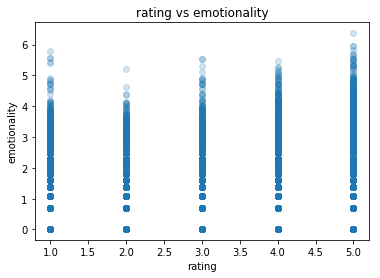

In [38]:
plt.scatter(ratings, emotionalities, alpha=.2)
plt.title('rating vs emotionality')
plt.xlabel('rating')
plt.ylabel('emotionality')
#not a very insightful plot, but still shows some tendency that reviews with rating 1 or 5 are emotional

### Top 10 most emotional reviews

In [39]:
# Top 10 reviews with highes emotionality:
# All top 10 reviews have rating 5 or 1 (which was expected)
for rank, kv in enumerate(sort[-1:-11:-1]):
    print('-------------------------------------------------------------------------------------------')
    print(f'Top {rank+1}: emotionality-score = {kv[1]:.3f}, rating = {ratings[kv[0]]}')
    print('-------------------------------------------------------------------------------------------')
    print(reviews[kv[0]])


-------------------------------------------------------------------------------------------
Top 1: emotionality-score = 6.387, rating = 5
-------------------------------------------------------------------------------------------
This review is going to compare 3 Ju-Ju-Be bags.  I'm writing a lot because I wish I had this info before I started shopping for a diaper bag.  I am a first time mom so I am probably packing different than a mom that's been around the block.  Also, we are cloth diapering, but not 100% of the time.  We use the disposable, biodegradable inserts for the cloth covers when we want to pack light - and those things take up less room than traditional disposables.  But I wanted a bag that gave me options for either type of diaper.  Here is what I found.  I hope reading this long post will help you save some time and return shipping fees while shopping!!!I already had the Ju-Ju-Be BFF and Be Prepared before I bought the Be Right Back backpack.  I bought them at a differ